<a href="https://colab.research.google.com/github/anmolkohli18/pytorch-practice-examples/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print("Pytorch version:", torch.__version__, "\nTorch vision version:", torchvision.__version__)

Pytorch version: 1.13.1+cu116 
Torch vision version: 0.14.1+cu116


In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [4]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

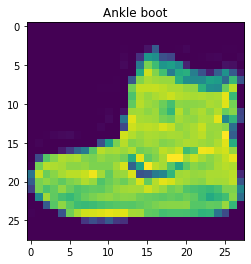

In [6]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])

Text(0.5, 1.0, 'Ankle boot')

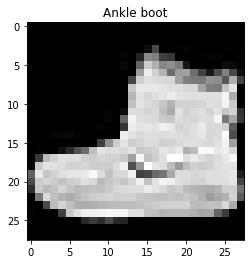

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

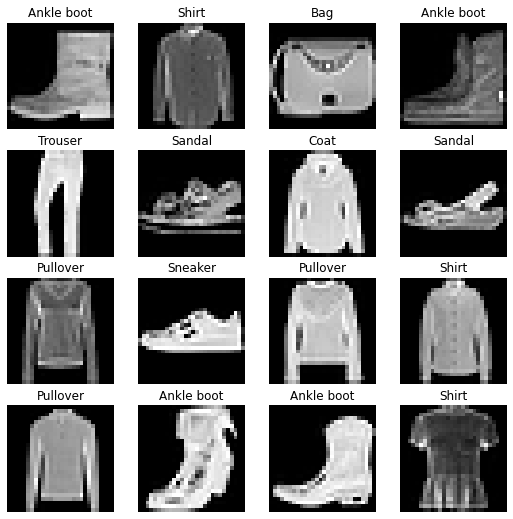

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print("Dataloaders:", train_dataloader, test_dataloader)
print("Length of train dataloader:", len(train_dataloader))
print("Length of test dataloader:", len(test_dataloader))

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x7f8b3c46f8e0> <torch.utils.data.dataloader.DataLoader object at 0x7f8b3c46feb0>
Length of train dataloader: 1875
Length of test dataloader: 313


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label tensor(6) size torch.Size([])


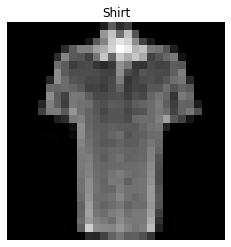

In [11]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print("Image size:", img.shape)
print("Label", label, "size", label.shape)

In [12]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print("Shape before flattening", x.shape, "-> [color_channels, height, width]")
print("Shape after flattening", output.shape, "-> [color_channels, height*width]")

Shape before flattening torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening torch.Size([1, 784]) -> [color_channels, height*width]


In [13]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))

model_0.to('cpu')

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [16]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [17]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print("Train time on", device, total_time, "seconds")
  return total_time

In [18]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print("Epoch:", epoch)

  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print("Looked at", f"{batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model_0(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print("Train loss:", train_loss.item(), "Test loss", test_loss.item(), "Test acc", test_acc)

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.5903892517089844 Test loss 0.5095350742340088 Test acc 82.03873801916933
Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4763319790363312 Test loss 0.47988998889923096 Test acc 83.19688498402556
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4550333023071289 Test loss 0.47663894295692444 Test acc 83.42651757188499
Train time on cpu 44.35007451700005 seconds


In [19]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

model_0_results = eval_model(model=model_0.to(device),
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [21]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [22]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)
                             ).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [23]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [24]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))
      
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")

In [25]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.09199 | Train accuracy: 61.34333
Test loss: 0.95636 | Test accuracy: 64.99601
Epoch: 1
Train loss: 0.78101 | Train accuracy: 71.92833
Test loss: 0.72227 | Test accuracy: 73.91174
Epoch: 2
Train loss: 0.67027 | Train accuracy: 75.93667
Test loss: 0.68500 | Test accuracy: 75.01997
Train time on cuda 38.04848958700006 seconds


In [26]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [27]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [28]:
conv_model = nn.Conv2d(in_channels=1,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

x = train_features_batch[0]

x.shape, conv_model(x).shape

(torch.Size([1, 28, 28]), torch.Size([10, 28, 28]))

In [29]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [30]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609

In [31]:
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [32]:
torch.manual_seed(42)

conv_model = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_model(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [33]:
print(conv_model.state_dict())

OrderedDict([('weight', tensor([[[[ 0.1471,  0.1597, -0.0451],
          [ 0.1768, -0.0422,  0.0388],
          [-0.0937,  0.1130,  0.1697]],

         [[-0.1412,  0.1673,  0.0360],
          [ 0.1422,  0.0261,  0.0928],
          [-0.0272,  0.1484,  0.0284]],

         [[-0.0898,  0.0491, -0.0887],
          [-0.0226, -0.0782,  0.1277],
          [-0.1519, -0.0887, -0.0543]]],


        [[[-0.1157,  0.0182, -0.1901],
          [ 0.1738, -0.1635,  0.1486],
          [ 0.0320, -0.0625,  0.1189]],

         [[ 0.0300,  0.1555,  0.0210],
          [-0.0607,  0.0517, -0.0522],
          [ 0.0810,  0.1718,  0.1112]],

         [[-0.0841,  0.1111,  0.0344],
          [ 0.0977, -0.1173, -0.1905],
          [-0.0744, -0.1476,  0.1579]]],


        [[[ 0.0554,  0.0797,  0.0609],
          [-0.0033,  0.1506, -0.1367],
          [ 0.0121, -0.1314,  0.0593]],

         [[-0.0663,  0.0590, -0.0401],
          [ 0.1596, -0.1141, -0.1148],
          [-0.1148,  0.1731,  0.0641]],

         [[ 0.1852, 

In [34]:
print("conv layer weight shape:", conv_model.weight.shape)
print("conv layer bias shape:", conv_model.bias.shape)

conv layer weight shape: torch.Size([10, 3, 3, 3])
conv layer bias shape: torch.Size([10])


In [35]:
print("Test image original shape:", test_image.shape)
print("Test image with unsqueezed dimension:", test_image.unsqueeze(dim=0).shape)

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_model(test_image.unsqueeze(dim=0))
print("Shape after conv layer:", test_image_through_conv.shape)

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print("Shape after going through conv and max pool:", test_image_through_conv_and_max_pool.shape)

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after conv layer: torch.Size([1, 10, 62, 62])
Shape after going through conv and max pool: torch.Size([1, 10, 31, 31])


In [36]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor: \n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"Max pool tensor: \n{max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor: 
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])
Max pool tensor: 
tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [38]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train loss: 0.59839 | Train accuracy: 78.19667
Test loss: 0.38846 | Test accuracy: 86.28195
Epoch 1
Train loss: 0.36189 | Train accuracy: 86.89833
Test loss: 0.35411 | Test accuracy: 87.17053
Epoch 2
Train loss: 0.32358 | Train accuracy: 88.34000
Test loss: 0.32847 | Test accuracy: 88.13898
Train time on cuda 47.17847224100001 seconds


In [39]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32847264409065247,
 'model_acc': 88.13897763578275}

In [40]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.328473,88.138978


In [41]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,44.350075
1,FashionMNISTModelV1,0.685001,75.019968,38.048490
2,FashionMNISTModelV2,0.328473,88.138978,47.178472


Text(0, 0.5, 'model')

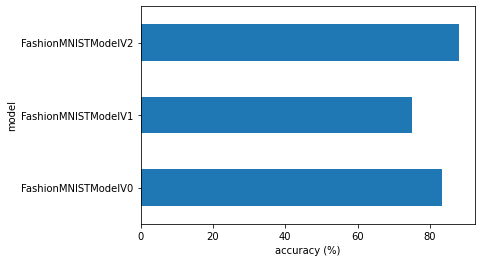

In [42]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [43]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [44]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
  test_samples.append(sample)
  test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [45]:
pred_probs = make_predictions(model=model_2, data=test_samples)

pred_probs[:2]

tensor([[3.1562e-07, 7.5296e-08, 1.5931e-07, 2.4502e-08, 5.4795e-08, 9.9992e-01,
         2.4099e-08, 3.5111e-06, 2.5332e-05, 5.1509e-05],
        [5.5931e-02, 8.5943e-01, 4.3897e-04, 6.5463e-02, 4.5245e-03, 2.0830e-04,
         1.3404e-02, 3.9542e-04, 1.5058e-04, 5.5678e-05]])

In [46]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3])

In [47]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 4],
 tensor([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3]))

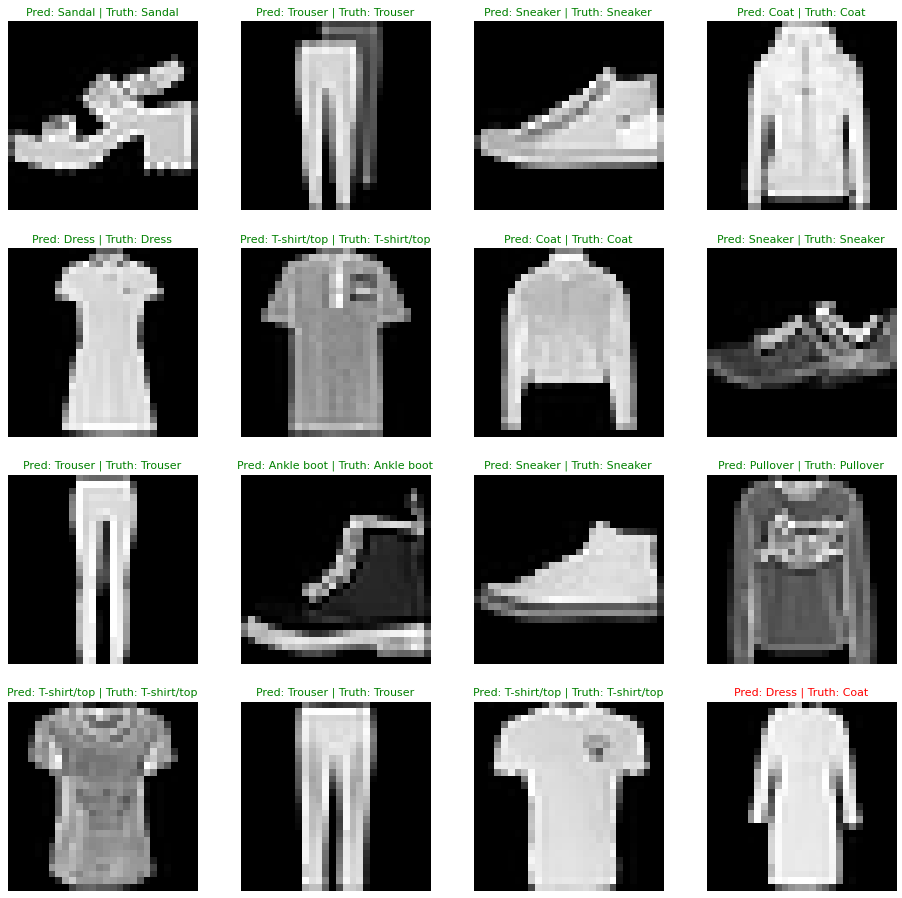

In [48]:
plt.figure(figsize=(16, 16))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=11, c="g")
  else:
    plt.title(title_text, fontsize=11, c="r")
  plt.axis("Off")

In [49]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [50]:
try:
  import mlxtend
  print("mlxtend version:", mlxtend.__version__)
  assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print("mlxtend version", mlxtend.__version__)

mlxtend version: 0.21.0


In [51]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.21.0


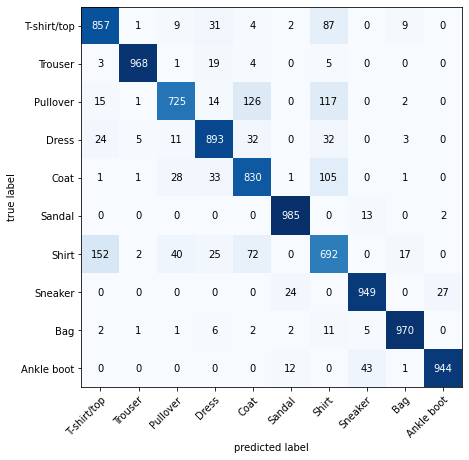

In [52]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10, 7)
)

In [53]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print("Saving model to:", MODEL_SAVE_PATH)
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [54]:
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=10)

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_2 = loaded_model_2.to(device)

In [55]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model = loaded_model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32847264409065247,
 'model_acc': 88.13897763578275}

In [56]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32847264409065247,
 'model_acc': 88.13897763578275}

In [57]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08,
              rtol=0.0001)

tensor(True)